In [2]:
import zipfile

In [5]:
import zipfile; zipfile.ZipFile('CASIA2.0_revised.zip').extractall()

In [3]:
%pip install tensorflow
import tensorflow as tf

Note: you may need to restart the kernel to use updated packages.


In [5]:
%pip install keras

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from tensorflow.keras.utils import to_categorical  # Corrected import
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from PIL import Image, ImageChops, ImageEnhance
import os
import itertools

#%% Function to convert to ELA (Error Level Analysis) image
def convert_to_ela_image(path, quality):
    temp_filename = 'temp_file_name.jpg'
    ela_filename = 'temp_ela.png'
    
    image = Image.open(path).convert('RGB')
    image.save(temp_filename, 'JPEG', quality=quality)
    temp_image = Image.open(temp_filename)
    
    ela_image = ImageChops.difference(image, temp_image)
    
    extrema = ela_image.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    if max_diff == 0:
        max_diff = 1
    scale = 255.0 / max_diff
    
    ela_image = ImageEnhance.Brightness(ela_image).enhance(scale)
    
    return ela_image

#%% Prepare the ELA image for model input
def prepare_image(image_path):
    return np.array(convert_to_ela_image(image_path, 98).resize([128, 128])).flatten() / 255.0

#%% Initialize datasets
X_train = [] # ELA converted images
X_test = []  # ELA converted images
Y_train = [] # 0 for fake, 1 for real 
Y_test = []  # 0 for fake, 1 for real


(200, 2)

In [3]:
#%%
import random
path = r'C:\Users\Bhavya\OneDrive\Desktop\stgi\smaller set\train\Au' 
j=0
for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        
        if filename.endswith('jpg') or filename.endswith('tif'):
            j=j+1
            full_path = os.path.join(dirname, filename)
            X_train.append(prepare_image(full_path))
            Y_train.append(0)
            if len(Y_train) % 500 == 0:
                print(f'Processing {len(Y_train)} images')
                print(j)
                
path = r'C:\Users\Bhavya\OneDrive\Desktop\stgi\smaller set\train\Tp' 
for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        j=j+1
        if filename.endswith('jpg') or filename.endswith('tif'):
            full_path = os.path.join(dirname, filename)
            X_train.append(prepare_image(full_path))
            Y_train.append(1)
            if len(Y_train) % 500 == 0:
                print(f'Processing {len(Y_train)} images')
                print(j)

#random.shuffle(X)
path = r'C:\Users\Bhavya\OneDrive\Desktop\stgi\smaller set\test\Au' 
for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        j=j+1
        if filename.endswith('jpg') or filename.endswith('bmp'):
            full_path = os.path.join(dirname, filename)
            X_test.append(prepare_image(full_path))
            Y_test.append(0)
            if len(Y_test) % 500 == 0:
                print(f'Processing {len(Y_test)} images')
                print(j)
                
path = r'C:\Users\Bhavya\OneDrive\Desktop\stgi\smaller set\test\Tp' 
for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        j=j+1
        if filename.endswith('jpg') or filename.endswith('tif'):
            full_path = os.path.join(dirname, filename)
            X_test.append(prepare_image(full_path))
            Y_test.append(1)
            if len(Y_test) % 500 == 0:
                print(f'Processing {len(Y_test)} images')
                print(j)

                
#%%

X_train = np.array(X_train)
X_test = np.array(X_test)
Y_train = to_categorical(Y_train, 2)

Y_test = to_categorical(Y_test, 2)
X_train = X_train.reshape(-1, 128, 128, 3)
X_test = X_test.reshape(-1, 128, 128, 3)
#%%

#X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size = 0.2, random_state=5)
#X = X.reshape(-1,1,1,1)
print(len(X_train), len(Y_train))
print(len(X_test), len(Y_test))

#%%

Processing 500 images
500
799 799
200 200


In [7]:

import numpy as np
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Dropout
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler

# Assuming X_train and X_test are your input images
# Ensure X_train and X_test are shaped (num_samples, 128, 128, 3)

# Example: Preparing binary masks for Y_train and Y_test
# Assuming original Y_train contains class labels, e.g., (num_samples, 2)
# You will need to convert these into binary masks where the forged regions are labeled as 1.

def prepare_masks(Y_labels, height=128, width=128):
    num_samples = Y_labels.shape[0]
    masks = np.zeros((num_samples, height, width, 1), dtype=np.float32)

    for i in range(num_samples):
        if Y_labels[i, 1] == 1:  # Assuming the second column indicates forgery
            masks[i, :, :, 0] = 1  # Set the entire mask to 1 for forged regions

    return masks

# Convert Y_train and Y_test to binary masks
Y_train_masks = prepare_masks(Y_train)  # Y_train is assumed to be (num_samples, 2)
Y_test_masks = prepare_masks(Y_test)    # Likewise for Y_test

In [17]:
from tensorflow.keras.layers import BatchNormalization
def build_model():
    model = Sequential()

    # First set of Conv layers
    model.add(Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(128, 128, 3)))
    model.add(BatchNormalization())
    model.add(Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(0.3))

    # Second set of Conv layers
    model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(0.3))

    # Third set of Conv layers
    model.add(Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    
    # Upsampling to restore original dimensions
    model.add(Conv2DTranspose(filters=64, kernel_size=(2, 2), strides=(2, 2), padding='same', activation='relu'))
    model.add(Conv2DTranspose(filters=32, kernel_size=(2, 2), strides=(2, 2), padding='same', activation='relu'))
    
    # Final layer for pixel-wise classification
    model.add(Conv2D(filters=1, kernel_size=(1, 1), activation='sigmoid', padding='same'))
    
    return model

# Build the modified model
model = build_model()
model.summary()

# Training parameters
epochs = 70
batch_size = 32 # Adjust based on your system's memory
init_lr = 0.0001

# Define the learning rate scheduler function
def scheduler(epoch, lr):
    if epoch < 25:
        return lr
    else:
        return lr * 0.96  

# Use the Adam optimizer
optimizer = Adam(learning_rate=init_lr)

# Compile the model with binary crossentropy loss for pixel-wise classification
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Define callbacks

lr_scheduler = LearningRateScheduler(scheduler)

# Train the model (assuming X_train, Y_train_masks are preprocessed)
hist = model.fit(X_train,
                 Y_train_masks,  # Using the binary masks
                 batch_size=batch_size,
                 epochs=epochs,
                 validation_data=(X_test, Y_test_masks),  # Ensure Y_test is also shaped correctly
                 callbacks=[lr_scheduler])

# Save the final model
model.save('model_casia_best_new.h5')

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_32 (Conv2D)          (None, 128, 128, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 128, 128, 32)      128       
 Normalization)                                                  
                                                                 
 conv2d_33 (Conv2D)          (None, 128, 128, 32)      9248      
                                                                 
 batch_normalization_1 (Bat  (None, 128, 128, 32)      128       
 chNormalization)                                                
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 64, 64, 32)        0         
 g2D)                                                            
                                                      

c:\Users\Bhavya\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [28]:
import cv2
import numpy as np

image_path = r'C:\Users\Bhavya\OneDrive\Desktop\stgi\smaller set\train\Tp\Tp_S_NRN_S_N_nat10157_nat10157_12040.jpg'
img = cv2.imread(image_path)
img_resized = cv2.resize(img, (128, 128))  # Resize to match model input
img_normalized = img_resized / 255.0  # Normalize pixel values
img_input = np.expand_dims(img_normalized, axis=0)  # Add batch dimension


In [29]:
prediction = model.predict(img_input)


1/1 [==============================] - 0s 272ms/step


In [31]:
predicted_mask = (prediction > 0.5).astype(np.uint8)  # Binary mask


1/1 [==============================] - 0s 38ms/step


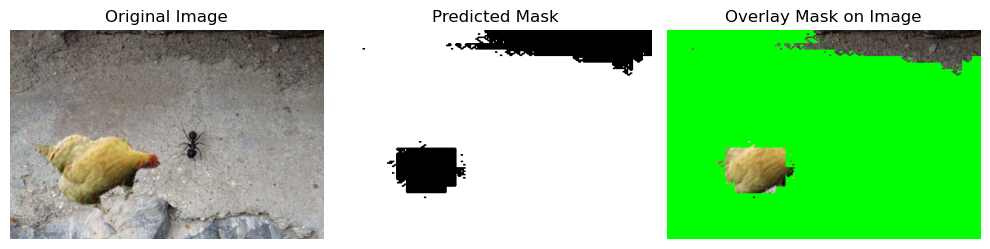

In [43]:
import matplotlib.pyplot as plt

# Load the image and make a prediction
image_path = r'C:\Users\Bhavya\OneDrive\Desktop\stgi\train\Tp\Tp_D_CRN_M_N_ani10112_ani00100_11648.jpg'
img = cv2.imread(image_path)
img_resized = cv2.resize(img, (128, 128))
img_normalized = img_resized / 255.0
img_input = np.expand_dims(img_normalized, axis=0)

# Predict the mask
prediction = model.predict(img_input)

# Postprocess the mask: convert to binary mask
predicted_mask = (prediction > 0.1).astype(np.uint8).squeeze()

# Resize the mask to the original image size for visualization
predicted_mask_resized = cv2.resize(predicted_mask, (img.shape[1], img.shape[0]))

# Visualize the original image, predicted mask, and the overlay
plt.figure(figsize=(10, 5))

# Original Image
plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')

# Predicted Mask
plt.subplot(1, 3, 2)
plt.imshow(predicted_mask_resized, cmap='gray')
plt.title('Predicted Mask')
plt.axis('off')

# Overlay Mask on Original Image
overlay = img.copy()
overlay[predicted_mask_resized > 0] = [0, 255, 0]  # Highlight mask areas in green

plt.subplot(1, 3, 3)
plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
plt.title('Overlay Mask on Image')
plt.axis('off')

plt.tight_layout()
plt.show()
